In [2]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions, summarize_results, measure_smoothness_with_df, compute_rsquared
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

from postprocessing.arima import smooth_nn_predictions_with_arima_auto


TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [3]:
TRAIN_PROPORTION = 0.9
MODE = "diff" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [4]:
data, all_gdps, all_gts = load_data()

In [5]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode=MODE,
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


## Simple Prediction Model

Using mps device


100%|██████████| 100/100 [00:01<00:00, 81.14it/s]


Final training loss: 0.01411503367125988
Final validation loss: 0.49500030279159546
Final validation R^2: 0.341994984856945
Best r squared: 0.36623771440346997 at epoch 58


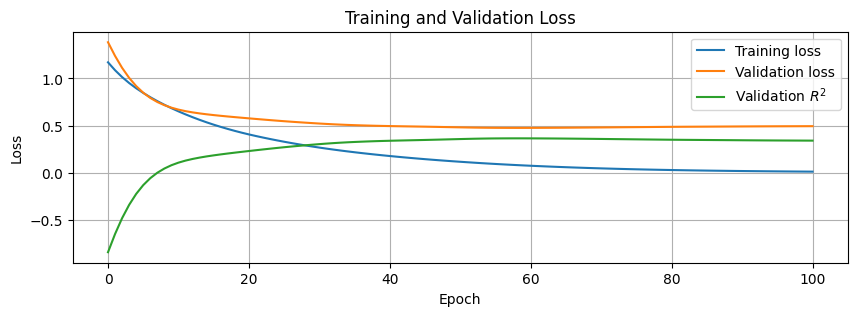

In [6]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

## High frequency predictions

In [7]:
# Predict for the high frequency data
device = get_device(False)
y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})

In [8]:
# Get the true GDPs
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid
all_true_gdps_country = np.concatenate([y_train, y_valid], axis=0)
all_dates = pd.concat([preprocessor.dates_train, preprocessor.dates_valid], axis=0)
all_true_gdps_country = pd.DataFrame({'date': all_dates, 'country': np.concatenate([country_train, country_valid], axis=0), 'y_true': np.concatenate([y_train, y_valid], axis=0)})

In [9]:
# Set the predicions to be plotted
predictions = y_pred_high_freq_country.copy()

# Add the true gdp for the points that we have
# Do not add multiple times the same point
predictions = predictions.merge(all_true_gdps_country, on=['date', "country"], how='left')

# Remove duplicates (as there is some noisy data with the same month)
predictions = predictions.drop_duplicates(subset=['date', 'country'])

# Rename y_pred to y_pred_high_freq
predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})

In [22]:
# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    #plt.fill_between(filtered_data["date"], filtered_data["y_pred_high_freq"] - 3 * filtered_data["stdv"], filtered_data["y_pred_high_freq"] + 3 * filtered_data["stdv"], alpha=0.2, color="blue")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
countries.sort()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

In [11]:
# Compute the smoothness of the predictions
predictions2 = predictions.copy()
predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results = measure_smoothness_with_df(predictions2)[1]
print(f"Smoothness results: {smoothness_results}")

Smoothness results: 0.7024426028971791


## Apply ARIMA smoothing

In [12]:
adjusted_predictions = smooth_nn_predictions_with_arima_auto(predictions)

In [13]:
def plot_by_country(selected_country):
    adjusted_filtered_data = adjusted_predictions[adjusted_predictions["country"] == selected_country]
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted", alpha=0.5)
    plt.plot(adjusted_filtered_data["date"], adjusted_filtered_data["y_pred_high_freq"], label="Adjusted Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    #plt.fill_between(filtered_data["date"], filtered_data["y_pred_high_freq"] - 3 * filtered_data["stdv"], filtered_data["y_pred_high_freq"] + 3 * filtered_data["stdv"], alpha=0.2, color="blue")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
# Plot the adjusted predictions
interact(plot_by_country, selected_country=dropdown)

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

<function __main__.plot_by_country(selected_country)>

In [15]:
# Compute the smoothness results
adjusted_predictions2 = adjusted_predictions.copy()
adjusted_predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results_adjusted = measure_smoothness_with_df(adjusted_predictions2)[1]

In [16]:
# Select the validation data (based on the cutoff date)
# Select the validation data (based on the cutoff date)
valid_pred = adjusted_predictions[(adjusted_predictions["date"] >= preprocessor.splitting_date) & (adjusted_predictions["y_true"].notna())]
valid_pred_y = valid_pred["y_pred_high_freq"]
valid_true_y = valid_pred["y_true"]

# Compute the R squared
r_squared = compute_rsquared(valid_true_y, valid_pred_y)

In [17]:
# Print the results
print(f"Smoothness results: {smoothness_results}")
print(f"Smoothness results ARIMA: {smoothness_results_adjusted}")

print(f"R squared: {validation_r_squared[-1]}")
print(f"R squared ARIMA: {r_squared}")


Smoothness results: 0.7024426028971791
Smoothness results ARIMA: 0.30249319374940437
R squared: 0.341994984856945
R squared ARIMA: 0.251399612540236


## Create scatter plot data (Rsquared and Smoothness)

In [18]:
# For N models, apply ARIMA and get the median R squared and smoothness
N_MODELS = 100
all_smoothness_results = []
all_r_squared = []
all_pred_initial = []
all_pred_arima = []
for i in tqdm(range(N_MODELS)):
    model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=False,
                                                                       seed=SEED + i)
    
    # Predict for the high frequency data
    y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
    y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})
    
    # Merge the predictions with the true GDPs
    predictions = y_pred_high_freq_country.copy()
    predictions = predictions.merge(all_true_gdps_country, on=['date', "country"], how='left')
    predictions = predictions.drop_duplicates(subset=['date', 'country'])
    predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})
    all_pred_initial.append(predictions)
    
    # Apply ARIMA to the predictions
    adjusted_predictions = smooth_nn_predictions_with_arima_auto(predictions)
    all_pred_arima.append(adjusted_predictions)

    # Compute the smoothness of the predictions
    adjusted_predictions2 = adjusted_predictions.copy()
    adjusted_predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
    smoothness_results_adjusted = measure_smoothness_with_df(adjusted_predictions2)
    
    # Compute the R squared
    valid_pred = adjusted_predictions[(adjusted_predictions["date"] >= preprocessor.splitting_date) & (adjusted_predictions["y_true"].notna())]
    valid_pred_y = valid_pred["y_pred_high_freq"]
    valid_true_y = valid_pred["y_true"]
    r_squared = compute_rsquared(valid_true_y, valid_pred_y)

    # Store the results
    all_smoothness_results.append(smoothness_results_adjusted)
    all_r_squared.append(r_squared)

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
# Aggregate the ARIMA results, do the median of the all_pred
all_pred_df = pd.concat(all_pred_arima)
all_pred_df = all_pred_df.groupby(['date', 'country']).median().reset_index()

# Compute the smoothness result on the median predictions
all_pred_df2 = all_pred_df.copy()
all_pred_df2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results_median = measure_smoothness_with_df(all_pred_df2)

# Compute the r squared on the validation data
valid_pred = all_pred_df[(all_pred_df["date"] >= preprocessor.splitting_date) & (all_pred_df["y_true"].notna())]
valid_pred_y = valid_pred["y_pred_high_freq"]
valid_true_y = valid_pred["y_true"]
r_squared_median = compute_rsquared(valid_true_y, valid_pred_y)

# Print the results
print(f"ARIMA then Aggregate R squared: {r_squared_median}")
print(f"ARIMA then Aggregate Bootstraped smoothness: {smoothness_results_median[1]}")

ARIMA then Aggregate R squared: 0.5273255130893598
ARIMA then Aggregate Bootstraped smoothness: 0.2043189456401204


In [21]:
# Compute the median smoothness results
all_smoothness_results_np = np.array(all_smoothness_results[1])
median_smoothness = np.median(all_smoothness_results_np, axis=0)

# Compute the median R squared
median_r_squared = np.median(all_r_squared)
mean_r_squared = np.mean(all_r_squared)

print(f"Median R squared: {median_r_squared}")
print(f"Median smoothness results: {median_smoothness}")


Median R squared: 0.27805095438291166
Median smoothness results: 0.30471434117709056
